# Coding project - Tumour segmentation

The image below is a slice of a brain MRI with a large tumour in it. The goal of this project is to create an algorithm to automatically segment the tumour.

Given that the resolution of the image is of 0.115 cm/px in both axis, estimate the area of the tumour (in cm²). 

# Report

I began by checking the shape of the image. As it is an rgb image, I converted it to a grayscale because the gradient method computes on a 1-channel image. I could have kept the RGB image and compute on each channel the gradient then merge it but the results were noisier. I also applied a median filter on the image before computing its gradient to denoise it.
After that, I needed to compute the local maxima to find the markers with the peak_local_max method. For that, i inversed the gradient image. I tried different parameters for it to find the borders of the tumor. I labeled the markers too so that they each have a unique ID.

I called the watershed method with the gradient and the markers computed. I saw that the background faded in a part of the brain so I put a marker on the background. This gave me the different regions of the image, we can clearly see the tumor being one region. 

When applying the mark_boundaries, we see the limits of the segmentation. As there is an oversegmentation, so I used a descriptor that will replace the pixel values of each region by the average value within that region. I printed the values of the regions resulting and found that the tumor was in the region with a value above 0.8, which I used to create a mask that selects the tumor only.

To compute the area of the tumor, I used the mask defined earlier and summed all the pixels of value 1 (which are the tumor). This gave me the size of the tumor which I multiplied by 0.115**2 to get the area in cm^2.


(218, 180, 3)


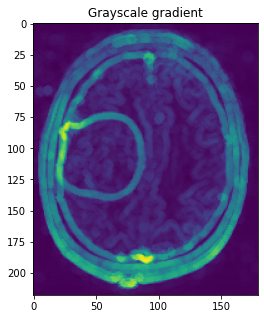

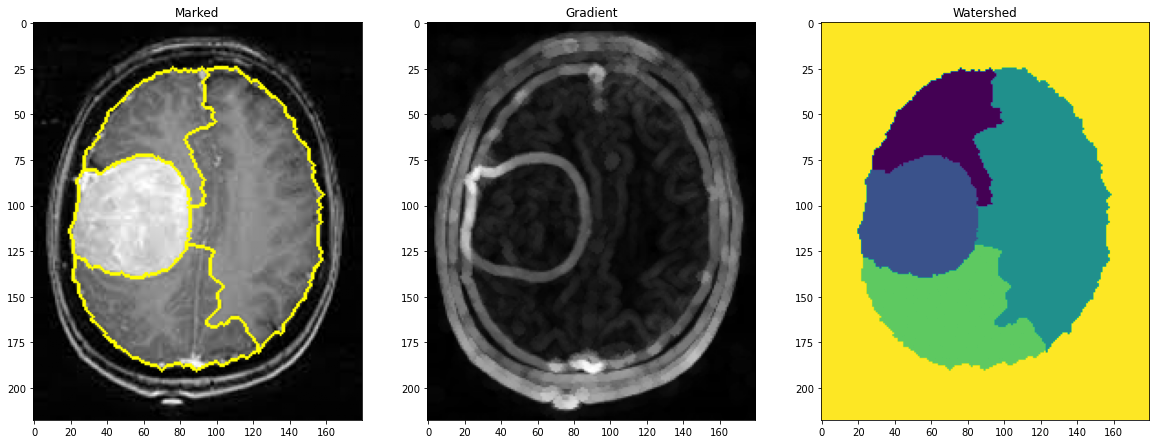

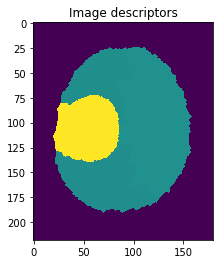

0.09577906728026665 0.8348546699681012
(218, 180)


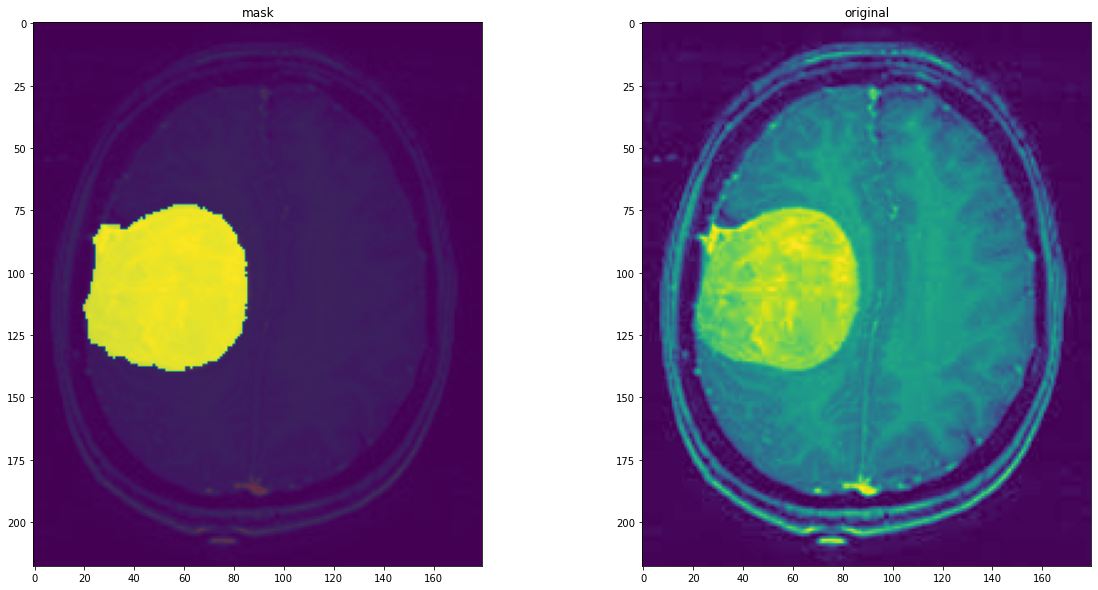

1


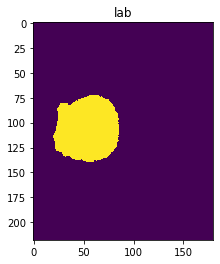

3516
404.34000000000003
46.499100000000006


In [19]:
import skimage.filters.rank as skr
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from skimage.io import imread,imshow
from scipy.ndimage import distance_transform_edt
from skimage.color import rgb2gray, rgb2hed, rgb2hsv
from skimage.filters import threshold_otsu,sobel,gaussian, rank
from skimage.morphology import opening, closing, disk, watershed
from skimage.segmentation import mark_boundaries
from skimage.feature import peak_local_max
from skimage.measure import label, regionprops,find_contours
from skimage.filters.rank import gradient


im= imread('mri_brain.jpg')
print(im.shape)
# the gradient has to be computed on a 1-channel image so we put on grayscale
# also apply a median filter to denoise
im=rgb2gray(im)
gradient = skr.gradient(skr.median(im), disk(3))

plt.figure(figsize=(15,5))
plt.imshow(gradient)
plt.title("Grayscale gradient")
plt.show()

gradient_i = gradient.max()-gradient # inverse gradient image so that local minima -> local maxima
#gives a unique id on each marker unless they are connected
markers = label(peak_local_max(gradient_i, indices=False, threshold_rel=0.98, min_distance=38))

#add marker to background
markers[im==0] = markers.max()+1
#grow region on the image starting from the markers
ws = watershed(gradient, markers)

plt.figure(figsize=(20,10))
plt.subplot(1,3,1)
plt.imshow(mark_boundaries(im,ws))
plt.title("Marked")
plt.subplot(1,3,2)
plt.imshow(gradient,cmap=plt.cm.gray)
plt.title("Gradient")
plt.subplot(1,3,3)
plt.imshow(ws)
plt.title("Watershed")
plt.show()


def get_descr(region):
        return region[:].mean()
descriptors=np.zeros((ws.max()+1))
im_descriptors=np.zeros_like(im)


for i in range(ws.min(),ws.max()+1):
    descriptors[i]=get_descr(im[ws==i])
    im_descriptors[ws==i]=descriptors[i]
plt.figure()
plt.imshow(im_descriptors)
plt.title("Image descriptors")
plt.show()

print(im_descriptors.min(), im_descriptors.max())
print(im_descriptors.shape)
mask=(im_descriptors[:,:]>0.8)

plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.imshow(im)
plt.imshow(mask, alpha=0.8)
plt.title('mask')
plt.subplot(1,2,2)
plt.imshow(im)#see an increasing distance when we go in the square ->gives info on the center of an object
plt.title('original')
plt.show()

#use the connectivity of the pixels in the mask to try a separation of the objects
#we want one label for each object
lab=label(mask, connectivity=1) #connectivity: determines if 2 pixels connected by diag are connected or not, so if use 2 (take diag into account->find fewer objects)


plt.figure()
plt.imshow(lab==1) #select the tumor
plt.title("lab")
plt.show()


obj_sizes=0
obj_sizes+=(lab==1).sum()#look at the number of pixels having that label (tumor) and sum them
print(obj_sizes)
print((obj_sizes*(0.115)*0.115))

